# Good Faith Newcomer Prediction

Aaron has a labeled dataset of newcomers to English Wikipedia. Newcomers are labeled as good-faith or bad-faith based on Wikipedians' judgements of the newcomers' edits in their first edit session. Aaron used STiki scores to construct a bayesian prediction model of good-faith newcomers. In this notebook, I'll try to reproduce his results using ORES scores as well as try out some other modeling strategies.

In [1]:
% matplotlib inline
import pandas as pd
import urllib
import requests
from scipy.stats import beta
import numpy as np
from sklearn.metrics import roc_auc_score
import datetime
import matplotlib.pyplot as plt 
import pickle
from math import log, factorial, exp

### Download newcomer quality data

In [2]:
DATA_URL = "https://datasets.wikimedia.org/public-datasets/enwiki/rise-and-decline/newbie_quality_sample.tsv"
_ = urllib.request.urlretrieve(DATA_URL, "newbie_quality_sample.tsv")

In [2]:
df = pd.read_csv("newbie_quality_sample.tsv", sep = '\t')
df.index = df.user_id
df["good_faith"] = df.category > 2 

In [3]:
df.head()

,user_id,category,good_faith
user_id,,,
8,8,3,True
10,10,3,True
19,19,4,True
22,22,3,True
27,27,3,True


In [4]:
df["good_faith"].value_counts()

True     875
False    188
Name: good_faith, dtype: int64

### Get early newcomer contribution history

In [6]:

def get_user_name(uid):
        url = 'http://en.wikipedia.org/w/api.php?action=query&format=json&list=users&usprop=&ususerids=%d'
        try:
            r = requests.get( url % uid).json()
            return r["query"]['users'][0]['name']
        except:
            print("Error getting username: ", uid)
            return None

def get_user_contribs(uname, uclimit = 100):
    params = {'action': 'query',
           'format': 'json',
           'list' : 'usercontribs',
           'uclimit': uclimit,
           'ucdir': 'newer',
           'ucprop': 'oresscores|ids|timestamp|title',
           'ucuser': uname
          }

    try:
        r = requests.get('http://en.wikipedia.org/w/api.php', params=params).json()
        return r["query"]['usercontribs']
    except:
        print("Error getting contribs: ", uname)
        return []

In [11]:
contribs = {}

for i, uid in enumerate(df.user_id):
    if i % 100 ==0:
        print(i)
        
    uname = get_user_name(uid)
    if uname is not None:
        contribs[uid] = get_user_contribs(uname, uclimit = 100)

with open('newbie_quality_sample_contributions.pkl', 'wb') as fp:
    pickle.dump(contribs, fp)

0
25
50
75
100
125
150
175
200
225
250
275
300
Error getting contribs:  Spinal83
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
Error getting contribs:  Tapatun
750
Error getting contribs:  AyeSpy
775
800
825
850
875
900
925
950
975
1000
1025
1050


In [6]:
with open('newbie_quality_sample_contributions.pkl', 'rb') as fp:
    contribs = pickle.load(fp)

### Get newcomer first edit session

In [7]:
def get_main_ns_contribs(contribs):
    return {k:[x for x in v if x['ns'] == 0] for k,v in contribs.items()}

def parse_dt(s):
    return datetime.datetime.strptime(s, '%Y-%m-%dT%H:%M:%SZ')

def get_first_edit_session(contribs, gap = 60):
    fes_contribs = {}
    
    for k,v in contribs.items():
        if len(v) <= 1:
            fes_contribs[k] = v
        else:
            session = [v[0]]
            t_prev = parse_dt(v[0]['timestamp'])
            for x in v[1:]:
                t_curr = parse_dt(x['timestamp'])
                delta = t_curr - t_prev
                
                if delta > datetime.timedelta(minutes=gap):
                    break
                else:
                    t_prev = t_curr
                    session.append(x)
            fes_contribs[k] = session
    return fes_contribs

def get_first_edit(contribs):
    return {k:v[:2] for k,v in contribs.items()}


In [8]:
fes_contribs = get_first_edit_session(contribs)
ns0_contribs = get_main_ns_contribs(contribs)
ns0_fes_contribs = get_first_edit_session(ns0_contribs)
ns0_fe_contribs = get_first_edit(ns0_contribs)

### Snuggle Model


In [9]:
class SnuggleScorer():

    def __init__(self, ):
        self.EPSILON = 0.005
    
    def fit(self, contribs, labels):
        
        contribs_0 = [contribs[uid] for uid in labels.query('good_faith == 0')['user_id'] if uid in contribs]
        self.scores_0 = [c['oresscores']['damaging']['true'] for cs in contribs_0 for c in cs]
        
        contribs_1 = [contribs[uid] for uid in labels.query('good_faith == 1')['user_id'] if uid in contribs]
        self.scores_1 = [c['oresscores']['damaging']['true'] for cs in contribs_1 for c in cs]
        
        
        self.a0, self.b0, _, _ = beta.fit(self.scores_0)
        self.a1, self.b1, _, _ = beta.fit(self.scores_1)
        self.model_0 = beta(self.a0, self.b0)
        self.model_1 = beta(self.a1, self.b1)
        
        self.p_0_prior = float(len(contribs_0)) / (len(contribs_0) + len(contribs_1))
        self.p_1_prior = 1 - self.p_0_prior
        
    
    
    def beta_likelihood(self, scores, model):
        """
        Straight from https://github.com/wikimedia/analytics-snuggle/blob/master/snuggle/desirability.py#L18-L27
        """
        log_p = log(factorial(len(scores)))
        for score in scores:
            log_p += log(
            model.cdf(min(score + self.EPSILON, 1)) - 
            model.cdf(max(score - self.EPSILON, 0.005))
            )

        return exp(log_p)
        

        
    def score(self, contribs):
        """
        Straight from https://github.com/wikimedia/analytics-snuggle/blob/master/snuggle/desirability.py#L30-L34
        """
        
        scores =[c['oresscores']['damaging']['true'] for c in contribs]
        
        p_0 = self.beta_likelihood(scores, self.model_0) * self.p_0_prior
        p_1 = self.beta_likelihood(scores, self.model_1) * self.p_1_prior
        
        return p_1 / (p_1 + p_0)

In [10]:
SC = SnuggleScorer()
SC.fit(ns0_fes_contribs, df)

/Users/ellerywulczyn/miniconda3/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:407: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*sqrt(a + b + 1) / (a + b + 2) / sqrt(a*b)


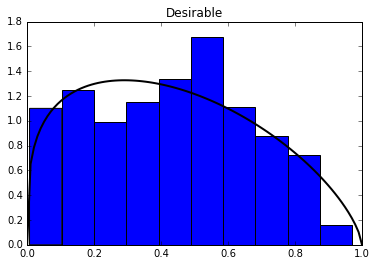

In [16]:
plt.title("Desirable")
plt.hist(SC.scores_1, normed = True)
x = np.linspace(0, 1, 100)
rv = beta(SC.a1, SC.b1)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')


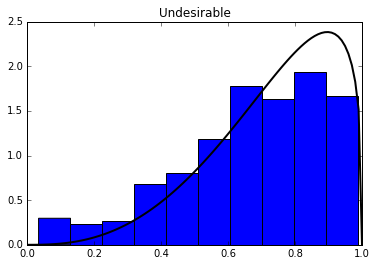

In [17]:
plt.title("Undesirable")
plt.hist(SC.scores_0, normed = True)
x = np.linspace(0, 1, 100)
rv = beta(SC.a0, SC.b0)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')


In [14]:
pred = df['user_id'].apply(lambda x: SC.score(ns0_fes_contribs.get(x, [])))
roc_auc_score(df['good_faith'], pred)

0.75583890577507606

In [15]:
# only include newcomers with a non-empty ns0_fes_contribs
df['has_ns0_fes'] = df['user_id'].apply(lambda x: len(ns0_fes_contribs[x]) > 0)
df_ns0_fes = df.query("has_ns0_fes == 1")
pred_ns0_fes = df_ns0_fes['user_id'].apply(lambda x: SC.score(ns0_fes_contribs.get(x, [])))
roc_auc_score(df_ns0_fes['good_faith'], pred_ns0_fes)

0.78589513713745274

The Snuggle paper reports an ROC of .88. We will need to figure out where the discrepancy comes from:
1. concecptual or implementation error in reproduction
2. difference in accuracy/semantics between ORES and STiki scores
3. small sample size effect in paper (n=150 vs n=1000)

### LSTM model
